In [ ]:
import os
import urllib.request

import audeer


# Get database source
source = 'http://emodb.bilderbar.info/download/download.zip'
src_dir = 'emodb-src'
if not os.path.exists(src_dir):
    urllib.request.urlretrieve(source, 'emodb.zip')
    audeer.extract_archive('emodb.zip', src_dir)

os.listdir(src_dir)

['lablaut', 'labsilb', 'silb', 'wav', 'erkennung.txt', 'erklaerung.txt']

In [ ]:
os.listdir(os.path.join(src_dir, 'wav'))[:3]

['16a05Tb.wav', '13a05Aa.wav', '03a02Nc.wav']

In [ ]:
import audformat
import pandas as pd

# Prepare functions for getting information from file names
def parse_names(names, from_i, to_i, is_number=False, mapping=None):
    for name in names:
        key = name[from_i:to_i]
        if is_number:
            key = int(key)
        yield mapping[key] if mapping else key


description = (
   'Berlin Database of Emotional Speech. '
   'A German database of emotional utterances '
   'spoken by actors '
   'recorded as a part of the DFG funded research project '
   'SE462/3-1 in 1997 and 1999. '
   'Recordings took place in the anechoic chamber '
   'of the Technical University Berlin, '
   'department of Technical Acoustics. '
   'It contains about 500 utterances '
   'from ten different actors '
   'expressing basic six emotions and neutral.'
)

files = sorted(
    [os.path.join('wav', f) for f in os.listdir(os.path.join(src_dir, 'wav'))]
)
names = [audeer.basename_wo_ext(f) for f in files]

emotion_mapping = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'fear',
    'F': 'happiness',
    'T': 'sadness',
    'N': 'neutral',
}
emotions = list(parse_names(names, from_i=5, to_i=6, mapping=emotion_mapping))

y = pd.read_csv(
    os.path.join(src_dir, 'erkennung.txt'),
    usecols=['Satz', 'erkannt'],
    index_col='Satz',
    delim_whitespace=True,
    encoding='Latin-1',
    decimal=',',
    converters={'Satz': lambda x: os.path.join('wav', x)},
).squeeze('columns')
y = y.loc[files]
y = y.replace(to_replace=u'\xa0', value='', regex=True)
y = y.replace(to_replace=',', value='.', regex=True)
confidences = y.astype('float').values

male = audformat.define.Gender.MALE
female = audformat.define.Gender.FEMALE
de = audformat.utils.map_language('de')
df_speaker = pd.DataFrame(
    index=pd.Index([3, 8, 9, 10, 11, 12, 13, 14, 15, 16], name='speaker'),
    columns=['age', 'gender', 'language'],
    data = [
        [31, male, de],
        [34, female, de],
        [21, female, de],
        [32, male, de],
        [26, male, de],
        [30, male, de],
        [32, female, de],
        [35, female, de],
        [25, male, de],
        [31, female, de],
   ],
)
speakers = list(parse_names(names, from_i=0, to_i=2, is_number=True))

transcription_mapping = {
    'a01': 'Der Lappen liegt auf dem Eisschrank.',
    'a02': 'Das will sie am Mittwoch abgeben.',
    'a04': 'Heute abend könnte ich es ihm sagen.',
    'a05': 'Das schwarze Stück Papier befindet sich da oben neben dem '
           'Holzstück.',
    'a07': 'In sieben Stunden wird es soweit sein.',
    'b01': 'Was sind denn das für Tüten, die da unter dem Tisch '
           'stehen.',
    'b02': 'Sie haben es gerade hochgetragen und jetzt gehen sie '
           'wieder runter.',
    'b03': 'An den Wochenenden bin ich jetzt immer nach Hause '
           'gefahren und habe Agnes besucht.',
    'b09': 'Ich will das eben wegbringen und dann mit Karl was '
           'trinken gehen.',
    'b10': 'Die wird auf dem Platz sein, wo wir sie immer hinlegen.',
}
transcriptions = list(parse_names(names, from_i=2, to_i=5))

In [ ]:
db = audformat.Database(
    name='emodb',
    source=source,
    usage=audformat.define.Usage.UNRESTRICTED,
    languages=[de],
    description=description,
    meta={
        'pdf': (
            'http://citeseerx.ist.psu.edu/viewdoc/'
            'download?doi=10.1.1.130.8506&rep=rep1&type=pdf'
        ),
    },
)

# Media
db.media['microphone'] = audformat.Media(
    format='wav',
    sampling_rate=16000,
    channels=1,
)

# Raters
db.raters['gold'] = audformat.Rater()

# Schemes
db.schemes['emotion'] = audformat.Scheme(
    labels=[str(x) for x in emotion_mapping.values()],
    description='Six basic emotions and neutral.',
)
db.schemes['confidence'] = audformat.Scheme(
    'float',
    minimum=0,
    maximum=1,
    description='Confidence of emotion ratings.',
)
db.schemes['age'] = audformat.Scheme(
    'int',
    minimum=0,
    description='Age of speaker',
)
db.schemes['gender'] = audformat.Scheme(
    labels=['female', 'male'],
    description='Gender of speaker',
)
db.schemes['language'] = audformat.Scheme(
    'str',
    description='Language of speaker',
)
db.schemes['transcription'] = audformat.Scheme(
    labels=transcription_mapping,
    description='Sentence produced by actor.',
)

# MiscTable
db['speaker'] = audformat.MiscTable(df_speaker.index)
db['speaker']['age'] = audformat.Column(scheme_id='age')
db['speaker']['gender'] = audformat.Column(scheme_id='gender')
db['speaker']['language'] = audformat.Column(scheme_id='language')
db['speaker'].set(df_speaker.to_dict(orient='list'))

# MiscTable as Scheme
db.schemes['speaker'] = audformat.Scheme(
    labels='speaker',
    dtype='int',
    description=(
        'The actors could produce each sentence as often as '
        'they liked and were asked to remember a real '
        'situation from their past when they had felt this '
        'emotion.'
    ),
)

# Tables
index = audformat.filewise_index(files)
db['files'] = audformat.Table(index)

db['files']['speaker'] = audformat.Column(scheme_id='speaker')
db['files']['speaker'].set(speakers)

db['files']['transcription'] = audformat.Column(scheme_id='transcription')
db['files']['transcription'].set(transcriptions)

db['emotion'] = audformat.Table(index)
db['emotion']['emotion'] = audformat.Column(
    scheme_id='emotion',
    rater_id='gold',
)
db['emotion']['emotion'].set(emotions)
db['emotion']['emotion.confidence'] = audformat.Column(
    scheme_id='confidence',
    rater_id='gold',
)
db['emotion']['emotion.confidence'].set(confidences / 100.0)

In [ ]:
db

name: emodb
description: Berlin Database of Emotional Speech. A German database of emotional utterances
  spoken by actors recorded as a part of the DFG funded research project SE462/3-1
  in 1997 and 1999. Recordings took place in the anechoic chamber of the Technical
  University Berlin, department of Technical Acoustics. It contains about 500 utterances
  from ten different actors expressing basic six emotions and neutral.
source: http://emodb.bilderbar.info/download/download.zip
usage: unrestricted
languages: [deu]
media:
  microphone: {type: other, format: wav, channels: 1, sampling_rate: 16000}
raters:
  gold: {type: human}
schemes:
  age: {description: Age of speaker, dtype: int, minimum: 0}
  confidence: {description: Confidence of emotion ratings., dtype: float, minimum: 0,
    maximum: 1}
  emotion:
    description: Six basic emotions and neutral.
    dtype: str
    labels: [anger, boredom, disgust, fear, happiness, sadness, neutral]
  gender:
    description: Gender of speak

In [ ]:
list(db)

['emotion', 'files', 'speaker']

In [ ]:
db['files'].get()[:10]

In [ ]:
db['emotion'].get()[:10]

In [ ]:
db['speaker'].get()[:10]

,age,gender,language
speaker,,,
3,31,male,deu
8,34,female,deu
9,21,female,deu
10,32,male,deu
11,26,male,deu
12,30,male,deu
13,32,female,deu
14,35,female,deu
15,25,male,deu


In [ ]:
db['files'].get(map={'speaker': ['speaker', 'age', 'gender']})[:10]

,speaker,transcription,age,gender
file,,,,
wav/03a01Fa.wav,3,a01,31,male
wav/03a01Nc.wav,3,a01,31,male
wav/03a01Wa.wav,3,a01,31,male
wav/03a02Fc.wav,3,a02,31,male
wav/03a02Nc.wav,3,a02,31,male
wav/03a02Ta.wav,3,a02,31,male
wav/03a02Wb.wav,3,a02,31,male
wav/03a02Wc.wav,3,a02,31,male
wav/03a04Ad.wav,3,a04,31,male


In [ ]:
import shutil


db_dir = audeer.mkdir('emodb')
shutil.copytree(
    os.path.join(src_dir, 'wav'),
    os.path.join(db_dir, 'wav'),
)
db.save(db_dir)

os.listdir(db_dir)

FileExistsError: ignored

In [ ]:
db = audformat.Database.load(db_dir)
db.name

'emodb'

In [ ]:
import os
root = '/content/drive/MyDrive/emodb/'
db.map_files(lambda x: os.path.join(root, x))

In [ ]:
df = db.tables['emotion'].df
df.head(n=1)

,emotion,emotion.confidence
file,,
/content/drive/MyDrive/emodb/wav/03a01Fa.wav,happiness,0.9


<Axes: ylabel='emotion'>

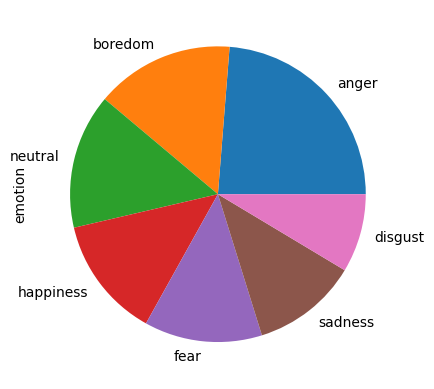

In [ ]:
df.emotion.value_counts().plot(kind='pie')

In [ ]:
df.index

Index(['/content/drive/MyDrive/emodb/wav/03a01Fa.wav',
       '/content/drive/MyDrive/emodb/wav/03a01Nc.wav',
       '/content/drive/MyDrive/emodb/wav/03a01Wa.wav',
       '/content/drive/MyDrive/emodb/wav/03a02Fc.wav',
       '/content/drive/MyDrive/emodb/wav/03a02Nc.wav',
       '/content/drive/MyDrive/emodb/wav/03a02Ta.wav',
       '/content/drive/MyDrive/emodb/wav/03a02Wb.wav',
       '/content/drive/MyDrive/emodb/wav/03a02Wc.wav',
       '/content/drive/MyDrive/emodb/wav/03a04Ad.wav',
       '/content/drive/MyDrive/emodb/wav/03a04Fd.wav',
       ...
       '/content/drive/MyDrive/emodb/wav/16b09Lb.wav',
       '/content/drive/MyDrive/emodb/wav/16b09Wb.wav',
       '/content/drive/MyDrive/emodb/wav/16b10Aa.wav',
       '/content/drive/MyDrive/emodb/wav/16b10Eb.wav',
       '/content/drive/MyDrive/emodb/wav/16b10Fb.wav',
       '/content/drive/MyDrive/emodb/wav/16b10Lb.wav',
       '/content/drive/MyDrive/emodb/wav/16b10Tb.wav',
       '/content/drive/MyDrive/emodb/wav/16b10Td.wav',

In [ ]:
!apt -qq install -y sox

In [ ]:
!apt install ffmpeg

In [ ]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.GeMAPSv01b,
    feature_level=opensmile.FeatureLevel.Functionals,
)
feats_df = smile.process_files(df.index)

In [ ]:
feats_df.head(n=1)

In [ ]:
print(df.shape, feats_df.shape)

(535, 2) (535, 62)


In [ ]:
test_labels = df.iloc[:100,].emotion
train_labels = df.iloc[100:,].emotion
test_feats = feats_df.iloc[:100,]
train_feats = feats_df.iloc[100:,]

In [ ]:
clf = svm.SVC()
clf.fit(train_feats, train_labels)
pred_labels  = clf.predict(test_feats)

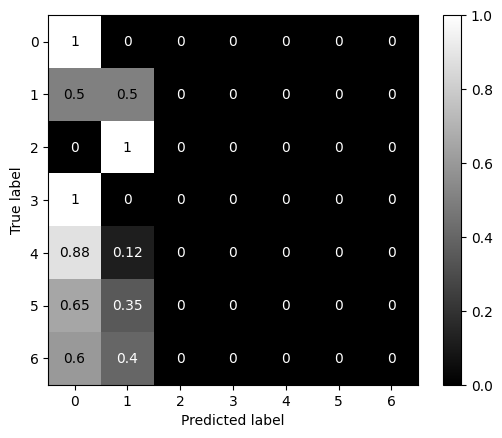

In [ ]:
cm = confusion_matrix(test_labels, pred_labels,  normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='gray')

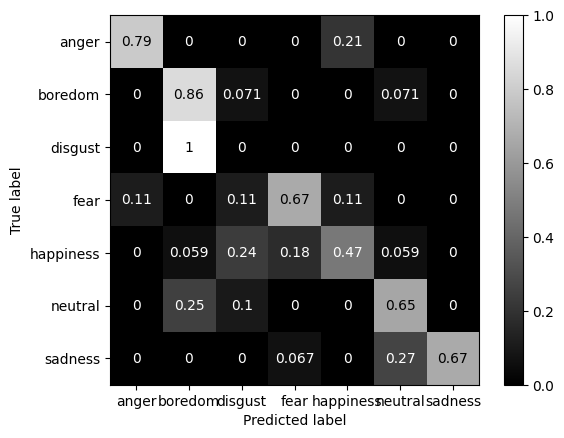

In [ ]:
clf = svm.SVC(kernel='linear', C=.001)
clf.fit(train_feats, train_labels)
pred_labels  = clf.predict(test_feats)
cm = confusion_matrix(test_labels, pred_labels,  normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot(cmap='gray')